# Cat and Dog Image Classifier

In this project, the goal was to make a CNN to classify images of cats and dogs and get at least **63% accuracy**.

The original project was made with TensorFlow/Keras, but in this notebook I will use PyTorch because I prefer it. I also will adapt some of the code to fit better what i'm doing.

You can see the original solution [here]("https://colab.research.google.com/drive/1_ck5d7UQjM_o2a6WMl96hrXid-S9DWr8?usp=sharing") and more information [here]("https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/cat-and-dog-image-classifier").

---

In [1]:
# Import required libraries
import torch
import torchvision

import os
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

c:\Users\Lucas\AppData\Local\Programs\Python\data-science\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get project files
data_path = Path('data')
image_path = data_path / 'cats_and_dogs'

if image_path.is_dir():
    print("Directory already exists, skipping download")
else:
    print("Creating directory and downloading data...")
    data_path.mkdir(exist_ok=True, parents=True)

    with open(data_path / 'cats_and_dogs.zip', 'wb') as f:
        request = requests.get("https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip")
        print("Downloading cats and dogs images")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "cats_and_dogs.zip", 'r') as zip_ref:
        print("Unzipping cats and dogs data")
        zip_ref.extractall(data_path)

    os.remove(data_path / 'cats_and_dogs.zip')

Directory already exists, skipping download


In [3]:
# Set key variables
train_dir = os.path.join(image_path, 'train')
validation_dir = os.path.join(image_path, 'validation')
test_dir = os.path.join(image_path, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
# Visualize
total_train, total_val, total_test

(2001, 1001, 51)

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

# Create the transformer
data_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

# Create Dataloaders and Datasets
train_data = ImageFolder(
    root=train_dir,
    transform=data_transform
)

val_data = ImageFolder(
    root=validation_dir,
    transform=data_transform
)

train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=True
)

val_dataloader = DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=False
)

len(train_dataloader), len(val_dataloader)

(16, 8)

In [6]:
class_names = train_data.classes
train_data, val_data, class_names

(Dataset ImageFolder
     Number of datapoints: 2000
     Root location: data\cats_and_dogs\train
     StandardTransform
 Transform: Compose(
                Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1000
     Root location: data\cats_and_dogs\validation
     StandardTransform
 Transform: Compose(
                Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 ['cats', 'dogs'])

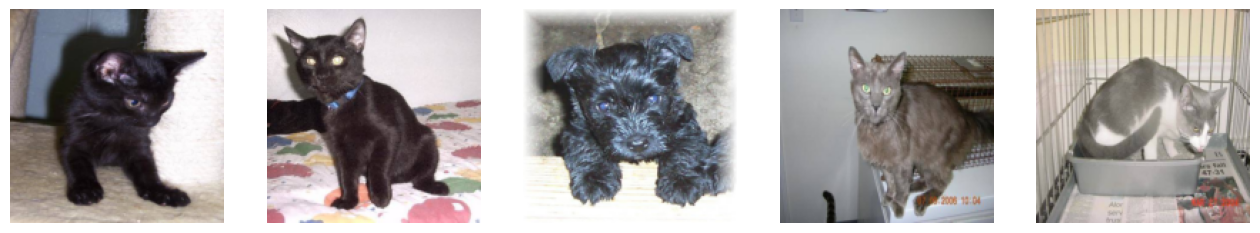

In [7]:
import random

def plotImages(dataset: torch.utils.data.Dataset, n: int):
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16,8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)


plotImages(train_data, 5)

In [8]:
# Recreate train dataloader with more transforms to not overfit
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data_augmented = ImageFolder(
    root=train_dir,
    transform=train_transforms,
)

train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=True
)

val_data_augmented = ImageFolder(
    root=validation_dir,
    transform=train_transforms,
)

val_dataloader_augmented = DataLoader(
    dataset=val_data_augmented,
    batch_size=batch_size,
    num_workers=os.cpu_count(),
    shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


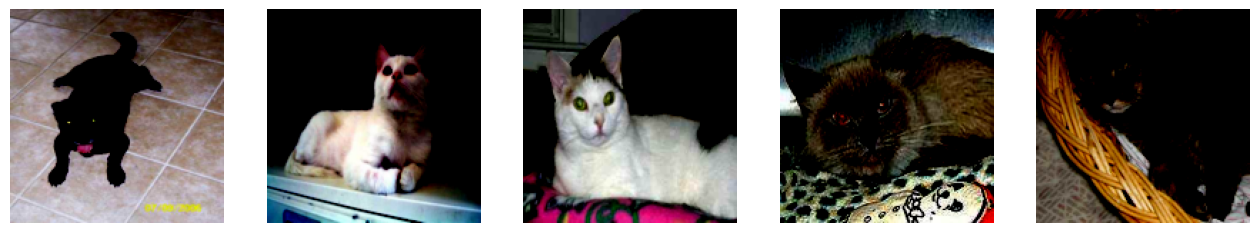

In [9]:
plotImages(train_data_augmented, 5)

In [10]:
from torch import nn
import torch.nn.functional as F

class CatAndDogConvNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)

        # Connected Layers
        self.fc1 = nn.Linear(in_features= 64 * 4 * 4, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = x.view(x.shape[0], -1)
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
model = CatAndDogConvNet().to(device)
model

CatAndDogConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [13]:
# Testing to correct the last layers
image_batch, label_batch = next(iter(train_dataloader_augmented))
model(image_batch.to(device))

tensor([[0.0227, 0.0531],
        [0.0185, 0.0526],
        [0.0233, 0.0514],
        [0.0251, 0.0517],
        [0.0280, 0.0529],
        [0.0238, 0.0551],
        [0.0232, 0.0515],
        [0.0207, 0.0491],
        [0.0221, 0.0502],
        [0.0303, 0.0482],
        [0.0239, 0.0495],
        [0.0187, 0.0539],
        [0.0205, 0.0517],
        [0.0249, 0.0515],
        [0.0198, 0.0526],
        [0.0270, 0.0468],
        [0.0243, 0.0457],
        [0.0247, 0.0455],
        [0.0255, 0.0501],
        [0.0246, 0.0523],
        [0.0257, 0.0500],
        [0.0348, 0.0501],
        [0.0283, 0.0464],
        [0.0338, 0.0453],
        [0.0322, 0.0523],
        [0.0199, 0.0504],
        [0.0197, 0.0517],
        [0.0199, 0.0535],
        [0.0330, 0.0525],
        [0.0194, 0.0500],
        [0.0250, 0.0519],
        [0.0202, 0.0540],
        [0.0269, 0.0508],
        [0.0182, 0.0525],
        [0.0272, 0.0510],
        [0.0179, 0.0538],
        [0.0248, 0.0566],
        [0.0185, 0.0541],
        [0.0

In [14]:
from torchinfo import summary

summary(model, input_size=[1, 3, 150, 150])

Layer (type:depth-idx)                   Output Shape              Param #
CatAndDogConvNet                         [1, 2]                    --
├─Conv2d: 1-1                            [1, 16, 74, 74]           1,216
├─Conv2d: 1-2                            [1, 32, 18, 18]           12,832
├─Conv2d: 1-3                            [1, 64, 9, 9]             18,496
├─Linear: 1-4                            [1, 500]                  512,500
├─Linear: 1-5                            [1, 50]                   25,050
├─Linear: 1-6                            [1, 2]                    102
Total params: 570,196
Trainable params: 570,196
Non-trainable params: 0
Total mult-adds (M): 12.85
Input size (MB): 0.27
Forward/backward pass size (MB): 0.83
Params size (MB): 2.28
Estimated Total Size (MB): 3.38

In [15]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

# Train the model
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

results = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = timer()

for epoch in tqdm(range(epochs)):
    ### TRAINING ###

    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(train_dataloader_augmented):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(train_dataloader_augmented)
    train_acc = train_acc / len(train_dataloader_augmented)

    ### VALIDATING ###
    model.eval()

    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(val_dataloader_augmented):
            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)

            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y)).sum().item()/len(val_pred_labels)

    val_loss = val_loss / len(val_dataloader)
    val_acc = val_acc / len(val_dataloader)

    print(f'Epoch {epoch} | Train loss: {train_loss:.4f} | Test acc: {train_acc:.4f} | Validation loss: {val_loss:.4f} | Validation acc: {val_acc:.4f}')

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['val_loss'].append(val_loss)
    results['val_acc'].append(val_acc)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

 10%|█         | 1/10 [01:17<11:38, 77.60s/it]

Epoch 0 | Train loss: 0.6941 | Test acc: 0.4877 | Validation loss: 0.6911 | Validation acc: 0.4995


 20%|██        | 2/10 [01:38<05:55, 44.38s/it]

Epoch 1 | Train loss: 0.6864 | Test acc: 0.5449 | Validation loss: 0.6663 | Validation acc: 0.6258


 30%|███       | 3/10 [01:57<03:48, 32.66s/it]

Epoch 2 | Train loss: 0.6651 | Test acc: 0.6006 | Validation loss: 0.6184 | Validation acc: 0.6593


 40%|████      | 4/10 [02:16<02:43, 27.19s/it]

Epoch 3 | Train loss: 0.6078 | Test acc: 0.6646 | Validation loss: 0.5846 | Validation acc: 0.6801


 50%|█████     | 5/10 [02:38<02:07, 25.53s/it]

Epoch 4 | Train loss: 0.5667 | Test acc: 0.6972 | Validation loss: 0.5805 | Validation acc: 0.6971


 60%|██████    | 6/10 [02:59<01:36, 24.02s/it]

Epoch 5 | Train loss: 0.5491 | Test acc: 0.7244 | Validation loss: 0.6014 | Validation acc: 0.6858


 70%|███████   | 7/10 [03:18<01:07, 22.40s/it]

Epoch 6 | Train loss: 0.5293 | Test acc: 0.7310 | Validation loss: 0.5550 | Validation acc: 0.7169


 80%|████████  | 8/10 [03:39<00:43, 21.71s/it]

Epoch 7 | Train loss: 0.4761 | Test acc: 0.7738 | Validation loss: 0.5619 | Validation acc: 0.7221


 90%|█████████ | 9/10 [03:57<00:20, 20.76s/it]

Epoch 8 | Train loss: 0.4411 | Test acc: 0.7795 | Validation loss: 0.5677 | Validation acc: 0.7215


100%|██████████| 10/10 [04:16<00:00, 25.64s/it]

Epoch 9 | Train loss: 0.4375 | Test acc: 0.7923 | Validation loss: 0.6184 | Validation acc: 0.6940
Total training time: 256.442 seconds


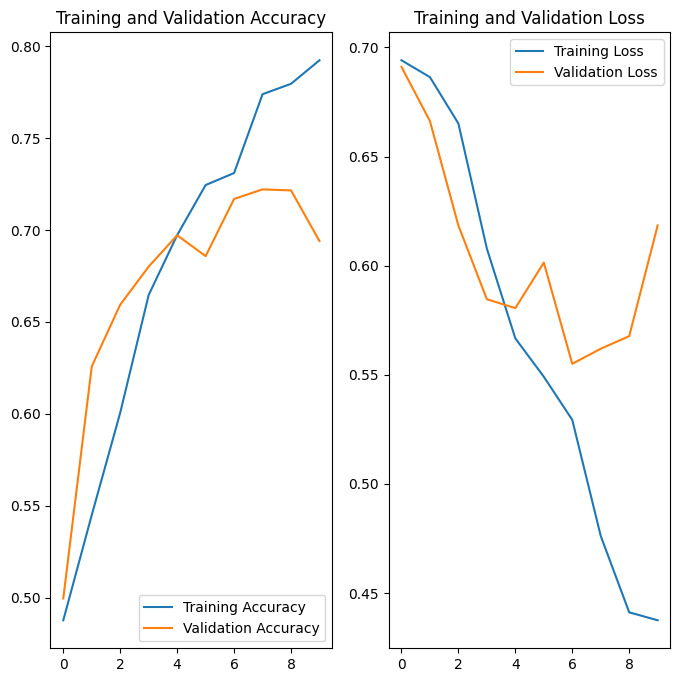

In [16]:
acc = results['train_acc']
val_acc = results['val_acc']

loss = results['train_loss']
val_loss = results['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*.jpg"))
test_data_paths[:5]

[WindowsPath('data/cats_and_dogs/test/1.jpg'),
 WindowsPath('data/cats_and_dogs/test/10.jpg'),
 WindowsPath('data/cats_and_dogs/test/11.jpg'),
 WindowsPath('data/cats_and_dogs/test/12.jpg'),
 WindowsPath('data/cats_and_dogs/test/13.jpg')]

In [63]:
from PIL import Image

pred_list = []

for path in tqdm(test_data_paths):
    pred_dict = {}

    pred_dict["image_path"] = path
    
    start_time = timer()

    img = Image.open(path)

    transformed_image = train_transforms(img).unsqueeze(0).to(device)

    model = model.to(device)
    model.eval()

    with torch.inference_mode():
        pred_logit = model(transformed_image)
        pred_prob = torch.softmax(pred_logit, dim=1)
        pred_label = torch.argmax(pred_prob, dim=1)
        pred_class = class_names[pred_label.cpu()]

        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_label"] = pred_label.cpu().item()
        pred_dict["pred_class"] = pred_class

        end_time = timer()
        pred_dict["timer_for_pred"] = round(end_time-start_time, 4)

    pred_list.append(pred_dict)

100%|██████████| 50/50 [00:00<00:00, 105.77it/s]


In [64]:
pred_list[:2]

[{'image_path': WindowsPath('data/cats_and_dogs/test/1.jpg'),
  'pred_prob': 0.5145,
  'pred_label': 0,
  'pred_class': 'cats',
  'timer_for_pred': 0.0388},
 {'image_path': WindowsPath('data/cats_and_dogs/test/10.jpg'),
  'pred_prob': 0.6782,
  'pred_label': 0,
  'pred_class': 'cats',
  'timer_for_pred': 0.0144}]

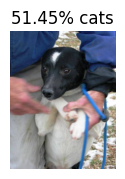

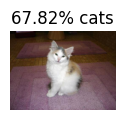

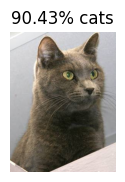

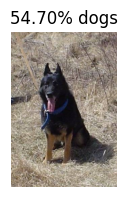

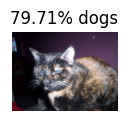

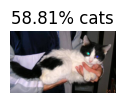

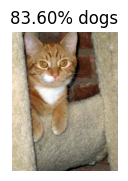

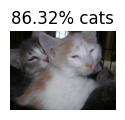

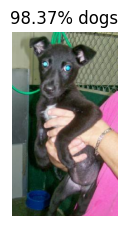

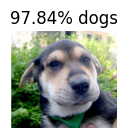

In [72]:
count = 0

for pred in pred_list[:10]:
    plt.figure(figsize=(16,9))
    img = Image.open(pred['image_path'])
    plt.subplot(1, 10, count+1)
    plt.imshow(img)
    plt.title(f"{pred['pred_prob'] * 100:.2f}% {pred['pred_class']}")
    plt.axis(False)

    count += 1

In [68]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(pred_list, answers):
  if round(probability['pred_label']) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!


**SUCCESS!**

Got 70% accuracy with model made in PyTorch and 68% with the one made in TensorFlow in the original project. 

The original TensorFlow model also had 43 M parameters compared to almost 600 K in the PyTorch one, making this model the far better one in accuracy and also size.

Although I wrote more code with Pytorch I prefer it over TensorFlow because it's more Pythonic and I can see better what I'm actually doing. I think I learn Machine Learning better with PyTorch instead of TensorFlow.